In [ ]:
! git clone https://github.com/Mayukhdeb/ml4a.git  
import os 
os.chdir("ml4a")


In [ ]:
## bunch of commands for a temp install, works on colab, might take some time to run 
!git checkout ml4a.net
!git submodule update --init --recursive
!python setup.py install
!pip install noise --force

In [123]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models

from ml4a import mask
from ml4a import image
from ml4a.models import basnet
from ml4a.models.torch_dreams import dreamer

In [124]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model)

dreamer init on:  cuda


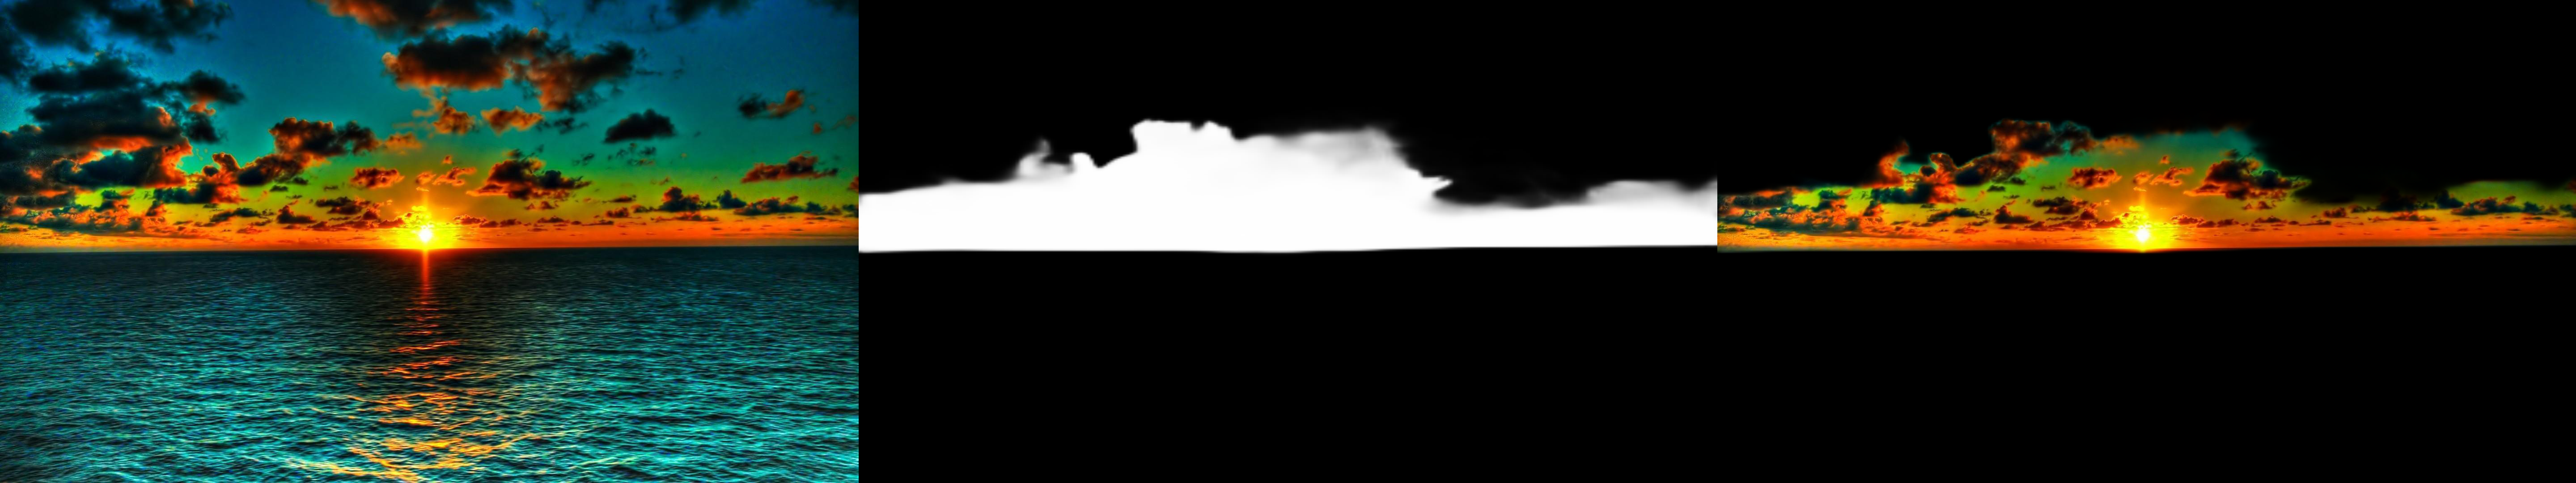

In [125]:
img = image.load_image('https://wallpaperaccess.com/full/1320173.jpg')

img_fg = basnet.get_foreground(img)
img_masked = mask.mask_image(img, img_fg)

all_images = image.concatenate_images([img, img_fg, img_masked])
image.display(all_images)

In [126]:
cv2.imwrite("horse.jpg", cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB))

True

(1080, 1920, 3)


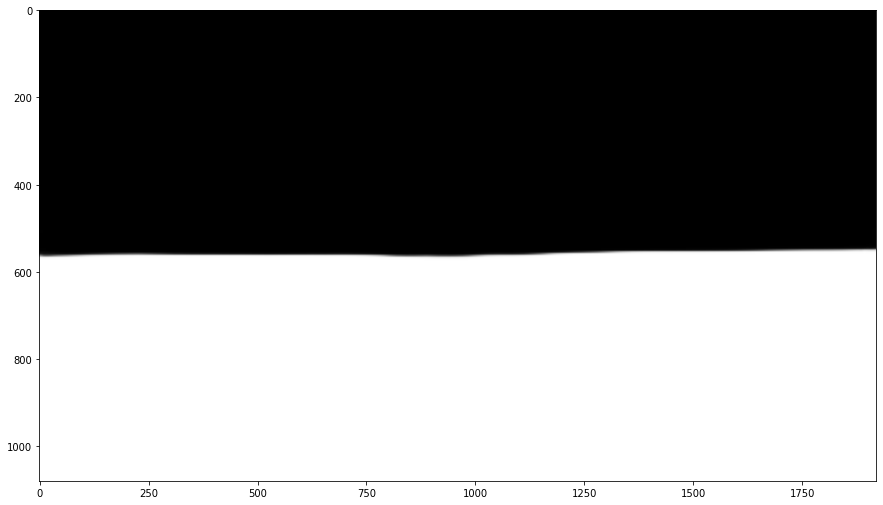

In [131]:
mask = 1- img_fg/255.0
print(mask.shape)

mask[0:500, :, :] = 0


plt.imshow(mask)

In [157]:

layers_to_use = [ model.Conv2d_4a_3x3.conv,  model.Mixed_6b.branch7x7dbl_2]

def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        if channel_number is not None:
            loss = layer_outputs[layer_number][channel_number].mean()
        else:
            loss = layer_outputs[layer_number].mean()

        return loss
    return custom_func


c1 = make_custom_func(0, 12)
c2 = make_custom_func(1, 88)



config = {
    "image_path": "horse.jpg",
    "layers": layers_to_use,
    "octave_scale": 1.1,
    "num_octaves": 15,
    "iterations": 30,
    "lr": 0.04,
    "max_rotation": 0.7,
    "grad_mask": [mask, (1-mask)*0.3],
    "custom_func": [c1, c2]
}


100%|██████████| 16/16 [01:23<00:00,  5.22s/it]


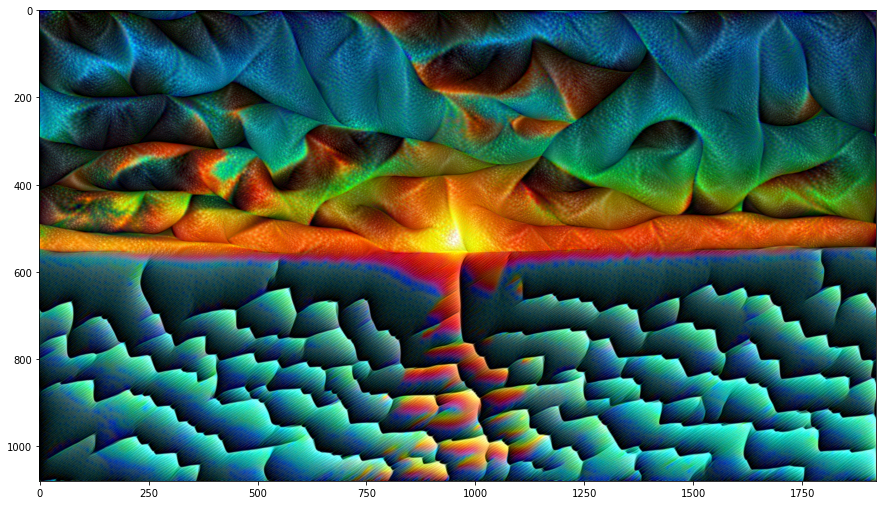

In [159]:
plt.rcParams['figure.figsize'] = 15, 15
out = dreamy_boi.deep_dream_with_masks(config)
# res = out*mask + np.array(img)*(1-mask)/255  ## replace non masked part with original 
plt.imshow(out)
plt.show()

In [164]:
out_p = cv2.cvtColor((out*255), cv2.COLOR_BGR2RGB)
cv2.imwrite("torch_dreams_ml4a.jpg", out_p)

True